In [7]:
from google.colab import drive
drive.mount('/content/drive')


KeyboardInterrupt: 

In [ ]:
import multiprocessing as mp
import statsmodels.api as sm
import pandas as pd
import numpy as np
from tqdm import tqdm
import time
import os
import glob
import warnings
warnings.filterwarnings('ignore')

sample_df = pd.read_csv('/content/drive/MyDrive/factor/data/data_5m/2021-01-04.csv')
sample_df.head()

,code,datetime,open,close,high,low,volume,money,date
0,000001.XSHE,2021-01-04 09:35:00,1998.4139,1946.0994,1998.4139,1935.6365,149014.6407,232597099.0,2021-01-04
1,000001.XSHE,2021-01-04 09:40:00,1942.9605,1945.0531,1950.2846,1937.7291,107353.7797,165336799.0,2021-01-04
2,000001.XSHE,2021-01-04 09:45:00,1942.9605,1949.2383,1954.4697,1929.3588,115148.1910,177234625.0,2021-01-04
3,000001.XSHE,2021-01-04 09:50:00,1949.2383,1954.4697,1963.8863,1947.1457,71354.1295,110667497.0,2021-01-04
4,000001.XSHE,2021-01-04 09:55:00,1954.4697,1946.0994,1954.4697,1944.0068,39160.3521,60488763.0,2021-01-04


In [ ]:
correlations = sample_df.groupby('code').apply(lambda x: x['close'].corr(x['volume']))
correlations_df = pd.DataFrame(correlations)
correlations_df


,0
code,
000001.XSHE,0.126032
000002.XSHE,0.256560
000004.XSHE,-0.175049
000005.XSHE,0.021703
000006.XSHE,-0.281269
...,...
688699.XSHG,-0.055081
688777.XSHG,0.112309
688788.XSHG,-0.596508


In [8]:
correlations_df = correlations.to_frame().reset_index().rename(columns={0:'close_volume_corr'})

In [6]:
from multiprocessing import Pool
import pandas as pd
import numpy as np
from tqdm import tqdm
import time
import os
import glob
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('/content/drive/MyDrive/factor')


output_folder = '/content/drive/MyDrive/factor/data/close_volume_corr'
path = '/content/drive/MyDrive/factor/data/data_5m'
all_files = glob.glob(path + "/*.csv")



def my_factor(filename):
    df = pd.read_csv(filename)

    df['datetime'] = pd.to_datetime(df['datetime'])

    # 拆分datetime列为date和time两列
    df['date'] = df['datetime'].dt.strftime('%Y-%m-%d')
    df['time'] = df['datetime'].dt.strftime('%H:%M:%S')
    date = df['date'].iloc[0]  # 日期存储

    df['vwap'] = df['money'] / df['volume']

    result_df = df.copy()

    # 日内信息辅助日频基础字段生成
    tmp = result_df.groupby('code').apply(lambda x: x['close'].corr(x['volume']))
    result = tmp.to_frame().reset_index().rename(columns={0:'close_volume_corr'})

    df = result.copy()

    # 创建文件夹（如果不存在）
    os.makedirs(output_folder, exist_ok=True)

    final = df.loc[:, ['code', 'close_volume_corr']]
    filename = os.path.join(output_folder, f'{date}.csv')
    final = final.sort_values(by='code', ascending=True)
    final.to_csv(filename, index=False)

def process_files(all_files):
    with Pool(4) as pool:  # 使用16个核
        results = [pool.apply_async(my_factor, args=(filename,)) for filename in all_files]

        # 获取所有结果
        for result in tqdm(results):
            result.get()

s = time.time()
process_files(all_files)  # 假设all_files是包含所有文件名的列表
e = time.time()

print(f'耗费{e-s}秒')

100%|██████████| 243/243 [21:47<00:00,  5.38s/it]

耗费1307.6147301197052秒


In [9]:
!pip install ray
import ray

#新生成字段与原始日频字段合成

daily_path = '/content/drive/MyDrive/factor/data/data_daily'
cvc_path = '/content/drive/MyDrive/factor/data/close_volume_corr'
output_folder = '/content/drive/MyDrive/factor/data/new_daily'
ray.shutdown()



#初始化ray
ray.init(num_cpus=4,num_gpus=0)
@ray.remote
def my_factor(filename):
    filename_min = cvc_path + '/' + filename   #读取分钟数据生成的字段
    filename_daily = daily_path + '/' + filename   #读取原始的日频数据
    df_min = pd.read_csv(filename_min)
    df_daily = pd.read_csv(filename_daily)
    date = df_daily['date'].values[0]
    merged = pd.merge(df_min, df_daily, on='code', how='inner')    #拼接

    final = merged.copy()

    # 创建文件夹（如果不存在）
    os.makedirs(output_folder, exist_ok=True)

    filename = os.path.join(output_folder, f'{date}.csv')
    final = final.sort_values(by='code', ascending=True)
    final.to_csv(filename, index=False)
    return


s=time.time()
res = []

for file_name in tqdm(all_files):
    file_name = os.path.basename(file_name)
    res.append(my_factor.remote(file_name))
results = ray.get(res)
e=time.time()
print(f'耗费{e-s}秒')

#重复运行必须要把ray关掉
ray.shutdown()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 MB 6.3 MB/s eta 0:00:00


2025-05-14 03:25:06,145	INFO worker.py:1888 -- Started a local Ray instance.
100%|██████████| 243/243 [00:00<00:00, 751.52it/s]


耗费101.39254188537598秒


In [10]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import os
import time
import glob
import warnings
warnings.filterwarnings('ignore')


#data
path = "/content/drive/MyDrive/factor/data/new_daily"
all_files = glob.glob(path + "/*.csv")   #把所有的数据文件文件名读取在一起

li = []


for filename in tqdm(all_files):
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)


frame = pd.concat(li, axis=0, ignore_index=True)
result_df = frame.sort_values(by=['code', 'date'], ascending=True)
result_df.index = range(len(result_df))
result_df

100%|██████████| 243/243 [00:04<00:00, 51.90it/s]


,code,close_volume_corr,date,open,close,low,high,volume,money,turnover_ratio
0,000001.XSHE,0.126032,2021-01-04,2306.70,2246.31,2226.99,2306.70,1286929.0,2.891682e+09,0.8009
1,000001.XSHE,0.089958,2021-01-05,2222.16,2194.38,2149.70,2231.82,1508123.0,3.284607e+09,0.9386
2,000001.XSHE,-0.216109,2021-01-06,2183.51,2362.25,2173.85,2362.25,1602181.0,3.648522e+09,0.9971
3,000001.XSHE,0.088208,2021-01-07,2357.42,2403.31,2322.40,2412.97,1311744.0,3.111275e+09,0.8163
4,000001.XSHE,0.569952,2021-01-08,2403.31,2397.27,2332.06,2427.47,989881.0,2.348316e+09,0.6160
...,...,...,...,...,...,...,...,...,...,...
1058890,689009.XSHG,0.277105,2021-12-27,65.00,67.08,63.56,68.43,3163564.0,2.086403e+08,0.7141
1058891,689009.XSHG,0.473949,2021-12-28,66.60,68.15,66.16,68.95,3561048.0,2.416030e+08,0.8039
1058892,689009.XSHG,0.520082,2021-12-29,68.50,67.58,66.64,69.68,3363471.0,2.282845e+08,0.7593
1058893,689009.XSHG,0.337465,2021-12-30,67.99,68.24,66.01,68.69,3059763.0,2.060038e+08,0.6907


In [14]:
%%time
pv_corr_avg = result_df.groupby('code').apply(lambda x: x['close_volume_corr'].rolling(20).mean())

CPU times: user 1.84 s, sys: 105 ms, total: 1.95 s
Wall time: 1.95 s


In [15]:
pv_corr_avg = pv_corr_avg.reset_index(level=[0,1])
pv_corr_avg = pv_corr_avg.drop(columns=['level_1'])
pv_corr_avg['date'] = result_df['date']
pv_corr_avg.columns = ['code','PV_corr_avg','date']

pv_corr_avg.tail()

,code,PV_corr_avg,date
1058890,689009.XSHG,0.139671,2021-12-27
1058891,689009.XSHG,0.145080,2021-12-28
1058892,689009.XSHG,0.185543,2021-12-29
1058893,689009.XSHG,0.183005,2021-12-30
1058894,689009.XSHG,0.191852,2021-12-31


In [16]:
#将日期列转换为datetime类型
df = pv_corr_avg
df['date']=pd.to_datetime(df['date'])

#保存文件夹路径
output_folder='/content/drive/MyDrive/factor/feature/factor_1_8_pv_corr_avg'
selected_columns=['code', 'date', 'PV_corr_avg']

os.makedirs(output_folder,exist_ok=True)

#创建日期索引并检查是否在dateframe中存在
date_index=pd.date_range(df['date'].min(),df['date'].max(),freq='D')
existing_dates=[d for d in date_index if d in df['date'].values]

#遍历每个日期如果它在dataframe中存在 则将其保存为单独的csv文件
for date in tqdm(existing_dates):
    group=df.loc[df['date']==date,selected_columns]
    filename=os.path.join(output_folder,f'{date.strftime("%Y-%m-%d")}.csv')
    group=group.sort_values(by='code',ascending=True)
    group = group.drop(columns = ['date'])
    group.to_csv(filename,index=False)

100%|██████████| 243/243 [00:13<00:00, 17.69it/s]


100%|██████████| 243/243 [06:35<00:00,  1.63s/it]


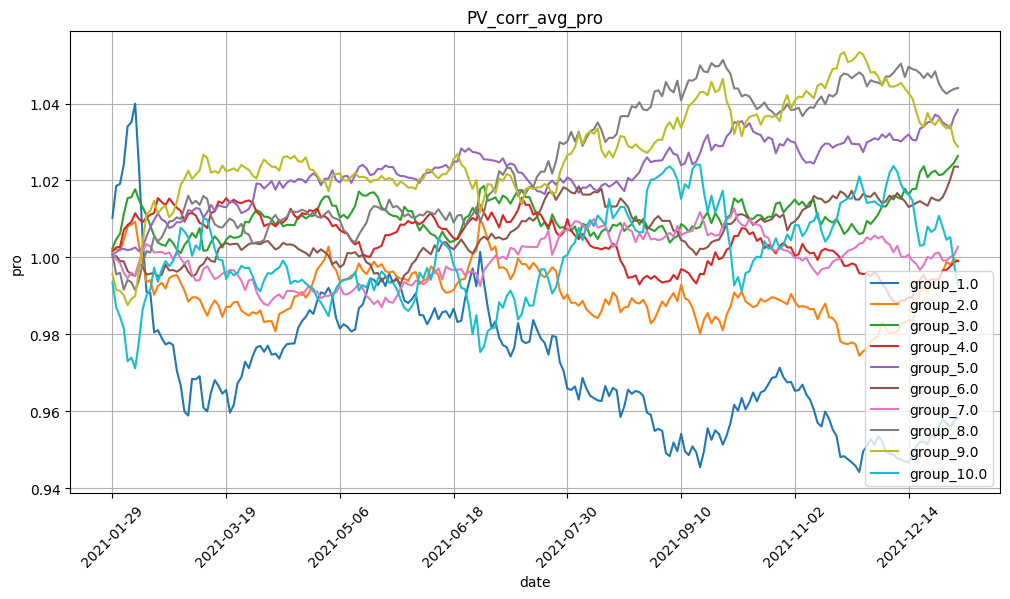

,factor_name,ic:,icir:,多头收益率:,多头波动率:,多头ir:,多头最大回撤:,对冲收益率:,对冲波动率:,对冲ir:,对冲最大回撤:
0,PV_corr_avg,0.001,0.018,0.274,0.152,1.798,7.4,-0.039,0.104,-0.38,14.0


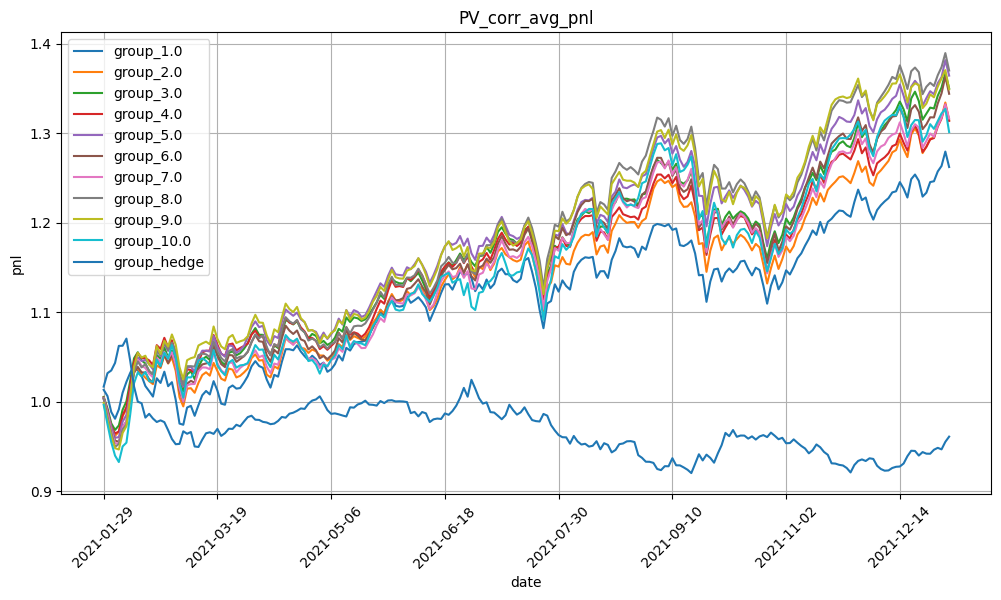

In [17]:
from backtest import BacktestAnalyzer
start_date = '2021-01-04'
end_date = '2021-12-31'
trade_date = '/content/drive/MyDrive/factor/data/date.pkl'
factor_path = '/content/drive/MyDrive/factor/feature/factor_1_8_pv_corr_avg'
ret_path = '/content/drive/MyDrive/factor/data/data_ret1'
ud_path = '/content/drive/MyDrive/factor/data/data_ud'
group = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

analyzer = BacktestAnalyzer(start_date, end_date, trade_date, factor_path, ret_path, ud_path, group)
analyzer.prepare_data()
analyzer.calculate_effectiveness()
analyzer.result

In [18]:
%%time
pv_corr_std = result_df.groupby('code').apply(lambda x: x['close_volume_corr'].rolling(20).std())

CPU times: user 1.87 s, sys: 242 ms, total: 2.11 s
Wall time: 2.12 s


In [19]:
pv_corr_std = pv_corr_std.reset_index(level=[0,1])
pv_corr_std = pv_corr_std.drop(columns=['level_1'])
pv_corr_std['date'] = result_df['date']
pv_corr_std.columns = ['code','PV_corr_std','date']

pv_corr_std.tail()

,code,PV_corr_std,date
1058890,689009.XSHG,0.302869,2021-12-27
1058891,689009.XSHG,0.308041,2021-12-28
1058892,689009.XSHG,0.301068,2021-12-29
1058893,689009.XSHG,0.299479,2021-12-30
1058894,689009.XSHG,0.305906,2021-12-31


In [20]:
#将日期列转换为datetime类型
df = pv_corr_std
df['date']=pd.to_datetime(df['date'])

#保存文件夹路径
output_folder='/content/drive/MyDrive/factor/feature/factor_1_8_pv_corr_std'
selected_columns=['code', 'date', 'PV_corr_std']

os.makedirs(output_folder,exist_ok=True)

#创建日期索引并检查是否在dateframe中存在
date_index=pd.date_range(df['date'].min(),df['date'].max(),freq='D')
existing_dates=[d for d in date_index if d in df['date'].values]

#遍历每个日期如果它在dataframe中存在 则将其保存为单独的csv文件
for date in tqdm(existing_dates):
    group=df.loc[df['date']==date,selected_columns]
    filename=os.path.join(output_folder,f'{date.strftime("%Y-%m-%d")}.csv')
    group=group.sort_values(by='code',ascending=True)
    group = group.drop(columns = ['date'])
    group.to_csv(filename,index=False)

100%|██████████| 243/243 [00:13<00:00, 17.49it/s]


100%|██████████| 243/243 [00:18<00:00, 12.84it/s]


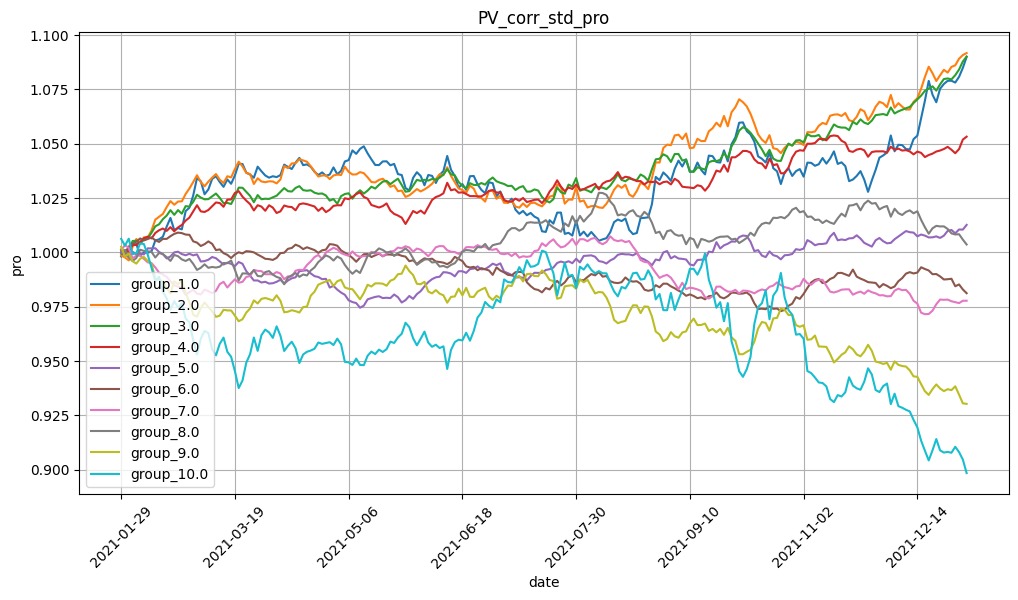

,factor_name,ic:,icir:,多头收益率:,多头波动率:,多头ir:,多头最大回撤:,对冲收益率:,对冲波动率:,对冲ir:,对冲最大回撤:
0,PV_corr_std,-0.008,-0.094,0.418,0.145,2.879,9.8,0.216,0.134,1.607,9.3


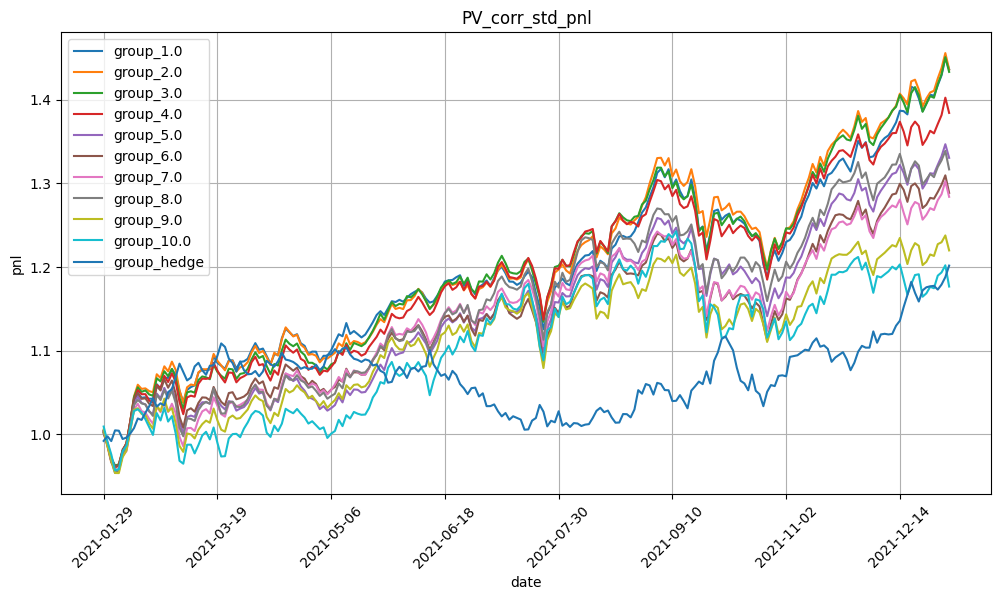

In [26]:
from backtest import BacktestAnalyzer
start_date = '2021-01-04'
end_date = '2021-12-31'
trade_date = '/content/drive/MyDrive/factor/data/date.pkl'
factor_path = '/content/drive/MyDrive/factor/feature/factor_1_8_pv_corr_std'
ret_path = '/content/drive/MyDrive/factor/data/data_ret1'
ud_path = '/content/drive/MyDrive/factor/data/data_ud'
group = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

analyzer = BacktestAnalyzer(start_date, end_date, trade_date, factor_path, ret_path, ud_path, group)
analyzer.prepare_data()
analyzer.calculate_effectiveness()
analyzer.result

In [27]:
reshaped_pv_corr_avg = pv_corr_avg.pivot(index='date', columns='code', values='PV_corr_avg')
reshaped_pv_corr_avg.tail()

code,000001.XSHE,000002.XSHE,000004.XSHE,000005.XSHE,000006.XSHE,000007.XSHE,000008.XSHE,000009.XSHE,000010.XSHE,000011.XSHE,...,688787.XSHG,688788.XSHG,688789.XSHG,688793.XSHG,688798.XSHG,688799.XSHG,688800.XSHG,688819.XSHG,688981.XSHG,689009.XSHG
date,,,,,,,,,,,,,,,,,,,,,
2021-12-27,-0.051534,0.163533,0.076077,0.135524,0.071639,NaN,0.008492,0.045230,0.006421,0.109204,...,0.070097,0.046707,-0.032893,-0.025491,0.000388,0.022530,-0.028139,0.092187,0.105064,0.139671
2021-12-28,-0.066040,0.138621,0.085150,0.138100,0.083170,-0.072575,0.018580,0.051325,0.035796,0.106983,...,0.093073,0.019502,-0.031776,-0.019993,0.005323,0.045577,-0.054625,0.083481,0.152655,0.145080
2021-12-29,-0.064941,0.123917,0.085946,0.131455,0.071222,-0.029549,0.012524,0.038381,0.023810,0.093946,...,0.067301,0.019380,-0.013775,0.020364,-0.009274,0.082941,-0.030276,0.088906,0.124958,0.185543
2021-12-30,-0.071980,0.118641,0.067530,0.100831,0.064704,0.004830,0.015953,0.035000,0.029611,0.059875,...,0.085032,-0.010116,0.001732,0.003161,-0.038858,0.075015,-0.058201,0.059696,0.095351,0.183005
2021-12-31,-0.095417,0.123633,0.087891,0.101297,0.065480,-0.003909,0.003901,0.021332,0.024274,0.082972,...,0.070757,-0.019370,0.001239,-0.011447,-0.077392,0.089456,-0.048729,0.070594,0.069019,0.191852


In [28]:
reshaped_pv_corr_std = pv_corr_std.pivot(index='date', columns='code', values='PV_corr_std')
reshaped_pv_corr_std.tail()

code,000001.XSHE,000002.XSHE,000004.XSHE,000005.XSHE,000006.XSHE,000007.XSHE,000008.XSHE,000009.XSHE,000010.XSHE,000011.XSHE,...,688787.XSHG,688788.XSHG,688789.XSHG,688793.XSHG,688798.XSHG,688799.XSHG,688800.XSHG,688819.XSHG,688981.XSHG,689009.XSHG
date,,,,,,,,,,,,,,,,,,,,,
2021-12-27,0.202257,0.309516,0.389075,0.209067,0.285244,NaN,0.171103,0.358576,0.269714,0.284124,...,0.334939,0.351788,0.279952,0.301300,0.322441,0.278742,0.278025,0.242174,0.369552,0.302869
2021-12-28,0.185990,0.306472,0.401803,0.211675,0.283379,0.328597,0.180307,0.363932,0.279334,0.282978,...,0.333395,0.345592,0.278962,0.301194,0.325627,0.250095,0.280662,0.236865,0.393230,0.308041
2021-12-29,0.186048,0.293335,0.400993,0.211701,0.289547,0.318061,0.185009,0.356880,0.280728,0.292962,...,0.341331,0.345448,0.247895,0.292059,0.317483,0.242216,0.288391,0.234736,0.385008,0.301068
2021-12-30,0.196027,0.295273,0.384929,0.191055,0.290264,0.338227,0.189953,0.354550,0.276250,0.316843,...,0.355950,0.311630,0.235190,0.302678,0.286907,0.245520,0.278107,0.244030,0.374500,0.299479
2021-12-31,0.200579,0.298099,0.379766,0.190601,0.290517,0.343786,0.194373,0.345989,0.284278,0.323328,...,0.345623,0.309952,0.235366,0.299875,0.301818,0.240956,0.275679,0.234761,0.354345,0.305906


In [30]:
def cs_regression(df1, df2):
    """
    对两个DataFrame的每一行执行截面回归，并返回一个包含残差的新DataFrame。
    如果存在inf或nan值，使用行的平均值（排除inf和nan）进行填充。
    如果一行全部是nan，则不进行回归，直接返回nan值。

    :param df1: DataFrame，包含自变量。
    :param df2: DataFrame，包含因变量。
    :return: 包含残差的DataFrame。
    """
    # 确保两个DataFrame的索引相同
    if not df1.index.equals(df2.index):
        raise ValueError("两个DataFrame的索引必须相同。")

    # 存储残差的列表
    residuals_list = []

    # 对每一行进行回归
    for idx in df1.index:
        # 提取自变量和因变量
        X = df1.loc[idx, :].replace([np.inf, -np.inf], np.nan)
        y = df2.loc[idx, :].replace([np.inf, -np.inf], np.nan)

        # 检查是否整行都是nan
        if X.isna().all() or y.isna().all():
            # 整行都是nan，则添加一个全为nan的残差
            residuals_list.append([np.nan] * len(X))
            continue

        # 计算行的平均值并填充nan值
        X = X.fillna(X.mean())
        y = y.fillna(y.mean())

        # 添加截距
        X = sm.add_constant(X)

        # 执行回归
        model = sm.OLS(y, X).fit()

        # 收集残差
        residuals = model.resid
        residuals_list.append(residuals)

    # 创建残差DataFrame
    residuals_df = pd.DataFrame(residuals_list, index=df1.index, columns = df1.columns)

    return residuals_df

In [31]:
ret = pd.read_pickle('/content/drive/MyDrive/factor/data/data_daily_pkl/ret.pkl')
ret['date'] = pd.to_datetime(ret.index)
ret = ret[(ret['date'] >='2021-01-04') & (ret['date'] <= '2021-12-31')]
ret = ret.drop(columns = ['date'])
mean_ret_20 = ret.rolling(20).mean()
mean_ret_20.index = reshaped_pv_corr_avg.index
mean_ret_20 = mean_ret_20[reshaped_pv_corr_avg.columns]

In [32]:
reshaped_pv_corr_avg_deRet20 = cs_regression(mean_ret_20, reshaped_pv_corr_avg)
reshaped_pv_corr_std_deRet20 = cs_regression(mean_ret_20, reshaped_pv_corr_std)

def cs_standard(df):#cross sectional
    return df.sub(df.mean(axis=1), axis=0).div(df.std(axis=1), axis=0)

standard_pv_corr_avg_deRet20 = cs_standard(reshaped_pv_corr_avg_deRet20)
standard_pv_corr_std_deRet20 = cs_standard(reshaped_pv_corr_std_deRet20)

standard_pv_corr_avg_deRet20.tail()

code,000001.XSHE,000002.XSHE,000004.XSHE,000005.XSHE,000006.XSHE,000007.XSHE,000008.XSHE,000009.XSHE,000010.XSHE,000011.XSHE,...,688787.XSHG,688788.XSHG,688789.XSHG,688793.XSHG,688798.XSHG,688799.XSHG,688800.XSHG,688819.XSHG,688981.XSHG,689009.XSHG
date,,,,,,,,,,,,,,,,,,,,,
2021-12-27,-1.805539,1.065384,-0.098610,0.691894,-0.188012,-0.013318,-1.158780,-0.388284,-1.022303,0.304638,...,-0.153298,-0.428047,-1.499869,-1.454157,-1.090718,-0.806541,-1.533706,0.207223,0.319329,0.720495
2021-12-28,-2.026034,0.689469,-0.012708,0.699335,-0.056381,-2.109600,-1.030494,-0.328288,-0.649644,0.251152,...,0.132454,-0.826004,-1.463748,-1.411116,-1.032308,-0.519107,-1.931172,0.055879,0.933455,0.753450
2021-12-29,-1.935149,0.554301,0.073605,0.666776,-0.162270,-1.457300,-1.047613,-0.452077,-0.740974,0.134873,...,-0.171337,-0.766506,-1.151352,-0.839668,-1.179884,0.030078,-1.598353,0.182568,0.619314,1.339251
2021-12-30,-1.916612,0.647911,-0.077362,0.398653,-0.110541,-0.866016,-0.884020,-0.386543,-0.549645,-0.181941,...,0.164377,-1.048536,-0.839483,-0.945283,-1.452841,0.041474,-1.834981,-0.096711,0.353721,1.433820
2021-12-31,-2.199242,0.698237,0.202884,0.394578,-0.098343,-1.000116,-1.032987,-0.586745,-0.611972,0.130398,...,-0.045271,-1.164440,-0.864535,-1.149011,-1.953634,0.225489,-1.621144,0.038882,-0.006667,1.546768


In [33]:
standard_pv_corr_std_deRet20.tail()

code,000001.XSHE,000002.XSHE,000004.XSHE,000005.XSHE,000006.XSHE,000007.XSHE,000008.XSHE,000009.XSHE,000010.XSHE,000011.XSHE,...,688787.XSHG,688788.XSHG,688789.XSHG,688793.XSHG,688798.XSHG,688799.XSHG,688800.XSHG,688819.XSHG,688981.XSHG,689009.XSHG
date,,,,,,,,,,,,,,,,,,,,,
2021-12-27,-1.948042,0.243581,1.868268,-1.808284,-0.252001,0.000260,-2.581174,1.242808,-0.570161,-0.274577,...,0.761978,1.105322,-0.362082,0.075022,0.506599,-0.385709,-0.399532,-1.134034,1.469007,0.108251
2021-12-28,-2.299064,0.153271,2.106191,-1.781058,-0.318007,0.616973,-2.445504,1.360942,-0.391072,-0.329131,...,0.715608,0.972284,-0.378395,0.054310,0.561203,-0.989097,-0.375975,-1.246768,1.937786,0.180603
2021-12-29,-2.322650,-0.149491,2.056600,-1.812869,-0.228069,0.371787,-2.386661,1.187668,-0.391447,-0.161013,...,0.840697,0.938793,-1.035373,-0.174189,0.360938,-1.184994,-0.269123,-1.318320,1.735354,-0.004486
2021-12-30,-2.124420,-0.112271,1.701796,-2.246905,-0.230018,0.786125,-2.348099,1.162135,-0.493266,0.309763,...,1.111755,0.255105,-1.278062,0.024915,-0.258528,-1.137390,-0.511218,-1.125033,1.520920,-0.080759
2021-12-31,-2.031205,-0.042396,1.633260,-2.262624,-0.208454,0.907169,-2.254835,0.995809,-0.314701,0.465110,...,0.918251,0.233929,-1.291305,-0.026354,0.059732,-1.229657,-0.509499,-1.319197,1.133916,0.080382


In [34]:
pv_corr_deRet20 = standard_pv_corr_avg_deRet20 + standard_pv_corr_std_deRet20
pv_corr_deRet20.tail()

code,000001.XSHE,000002.XSHE,000004.XSHE,000005.XSHE,000006.XSHE,000007.XSHE,000008.XSHE,000009.XSHE,000010.XSHE,000011.XSHE,...,688787.XSHG,688788.XSHG,688789.XSHG,688793.XSHG,688798.XSHG,688799.XSHG,688800.XSHG,688819.XSHG,688981.XSHG,689009.XSHG
date,,,,,,,,,,,,,,,,,,,,,
2021-12-27,-3.753581,1.308965,1.769658,-1.116389,-0.440013,-0.013058,-3.739954,0.854524,-1.592463,0.030061,...,0.608680,0.677275,-1.861951,-1.379135,-0.584119,-1.192251,-1.933238,-0.926810,1.788336,0.828747
2021-12-28,-4.325098,0.842740,2.093483,-1.081722,-0.374388,-1.492627,-3.475998,1.032654,-1.040717,-0.077978,...,0.848062,0.146280,-1.842143,-1.356807,-0.471105,-1.508203,-2.307147,-1.190888,2.871241,0.934053
2021-12-29,-4.257800,0.404810,2.130205,-1.146093,-0.390339,-1.085513,-3.434274,0.735590,-1.132421,-0.026139,...,0.669360,0.172287,-2.186725,-1.013857,-0.818946,-1.154916,-1.867476,-1.135752,2.354667,1.334765
2021-12-30,-4.041031,0.535639,1.624434,-1.848252,-0.340558,-0.079891,-3.232119,0.775592,-1.042911,0.127822,...,1.276132,-0.793431,-2.117545,-0.920369,-1.711369,-1.095917,-2.346199,-1.221744,1.874641,1.353061
2021-12-31,-4.230447,0.655841,1.836144,-1.868046,-0.306798,-0.092947,-3.287823,0.409064,-0.926673,0.595508,...,0.872979,-0.930511,-2.155840,-1.175365,-1.893902,-1.004168,-2.130643,-1.280315,1.127249,1.627150


In [35]:
long_format_pv_corr_deRet20 = pv_corr_deRet20.reset_index().melt(id_vars=['date'], var_name='code', value_name='pv_corr_deRet20')
long_format_pv_corr_deRet20.tail()

,date,code,pv_corr_deRet20
1122412,2021-12-27,689009.XSHG,0.828747
1122413,2021-12-28,689009.XSHG,0.934053
1122414,2021-12-29,689009.XSHG,1.334765
1122415,2021-12-30,689009.XSHG,1.353061
1122416,2021-12-31,689009.XSHG,1.627150


In [36]:
#将日期列转换为datetime类型
df = long_format_pv_corr_deRet20
df['date']=pd.to_datetime(df['date'])

#保存文件夹路径
output_folder='/content/drive/MyDrive/factor/feature/factor_1_8_pv_corr_deRet20'
selected_columns=['code', 'date', 'pv_corr_deRet20']

os.makedirs(output_folder,exist_ok=True)

#创建日期索引并检查是否在dateframe中存在
date_index=pd.date_range(df['date'].min(),df['date'].max(),freq='D')
existing_dates=[d for d in date_index if d in df['date'].values]

#遍历每个日期如果它在dataframe中存在 则将其保存为单独的csv文件
for date in tqdm(existing_dates):
    group=df.loc[df['date']==date,selected_columns]
    filename=os.path.join(output_folder,f'{date.strftime("%Y-%m-%d")}.csv')
    group=group.sort_values(by='code',ascending=True)
    group = group.drop(columns = ['date'])
    group.to_csv(filename,index=False)

100%|██████████| 243/243 [00:14<00:00, 16.63it/s]


100%|██████████| 243/243 [00:19<00:00, 12.25it/s]


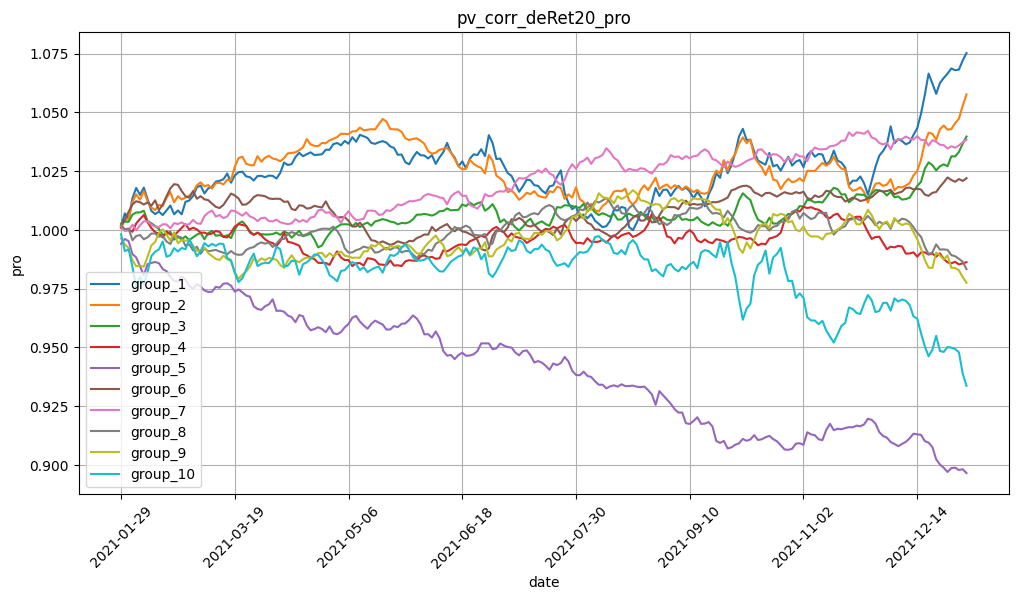

,factor_name,ic:,icir:,多头收益率:,多头波动率:,多头ir:,多头最大回撤:,对冲收益率:,对冲波动率:,对冲ir:,对冲最大回撤:
0,pv_corr_deRet20,-0.004,-0.073,0.4,0.138,2.901,8.5,0.158,0.1,1.589,5.4


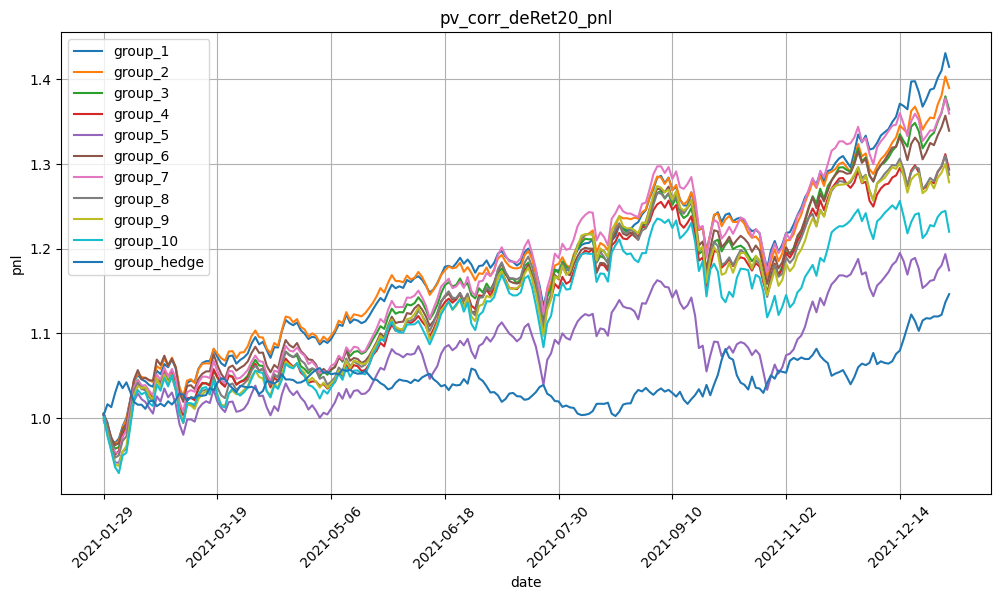

In [37]:
from backtest import BacktestAnalyzer
start_date = '2021-01-04'
end_date = '2021-12-31'
trade_date = '/content/drive/MyDrive/factor/data/date.pkl'
factor_path = '/content/drive/MyDrive/factor/feature/factor_1_8_pv_corr_deRet20'
ret_path = '/content/drive/MyDrive/factor/data/data_ret1'
ud_path = '/content/drive/MyDrive/factor/data/data_ud'
group = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

analyzer = BacktestAnalyzer(start_date, end_date, trade_date, factor_path, ret_path, ud_path, group)
analyzer.prepare_data()
analyzer.calculate_effectiveness()
analyzer.result

In [38]:
def rolling_time_series_regression(stock_data):
    """
    对每只股票的20个相关系数进行时序回归。

    :param stock_data: DataFrame，包含股票的相关系数数据。假设有一个名为'time'的列和一个名为'correlation'的列。
    :return: 包含回归系数的DataFrame。
    """
    # 存储结果的字典
    regression_results = {}

    # 对每只股票进行滚动回归
    for stock in tqdm(stock_data.columns[:10]):
        # 筛选特定股票的数据
        stock_df = stock_data[stock]

        # 存储每个回归的系数
        coefficients = []

        # 进行滚动回归
        for i in range(len(stock_df) - 19):
            # 提取20个数据点
            window = stock_df.iloc[i:i+20]
            window = window.fillna(window.mean())

            # 定义自变量和因变量
            X = sm.add_constant(range(1,21))  # 添加常数项
            y = window.values

            # 执行回归
            model = sm.OLS(y, X).fit()

            # 获取回归系数
            coef = model.params[1]  # 提取时间的系数
            coefficients.append(coef)

        # 将结果存入字典
        regression_results[stock] = coefficients

    # 转换为DataFrame
    results_df = pd.DataFrame(regression_results,index = stock_data.index[19:])

    return results_df

In [39]:
def rolling_regression_for_stock(stock, stock_data):
    """
    对单只股票的相关系数进行滚动时序回归。

    :param stock: 股票代码。
    :param stock_data: DataFrame，包含股票的相关系数数据。
    :return: 回归系数列表。
    """
    stock_df = stock_data[stock]
    coefficients = []

    for i in range(len(stock_df) - 19):
        window = stock_df.iloc[i:i+20]
        window = window.fillna(window.mean())
        X = sm.add_constant(range(1, 21))  # 添加常数项
        y = window.values

        model = sm.OLS(y, X).fit()
        coef = model.params[1]  # 提取时间的系数
        coefficients.append(coef)

    return stock, coefficients

def rolling_time_series_regression_mp(stock_data):
    """
    对DataFrame中所有股票的相关系数进行滚动时序回归。

    :param stock_data: DataFrame，包含股票的相关系数数据。
    :return: 包含回归系数的DataFrame。
    """
    regression_results = {}
    with Pool(16) as pool:
        results = [pool.apply_async(rolling_regression_for_stock, args=(stock, stock_data))
                   for stock in stock_data.columns]

        for result in tqdm(results):
            stock, coefficients = result.get()
            regression_results[stock] = coefficients

    results_df = pd.DataFrame(regression_results, index=stock_data.index[19:])
    return results_df

In [42]:
assert isinstance(reshaped_pv_corr_avg, pd.DataFrame)

pv_corr_trend = rolling_time_series_regression_mp(reshaped_pv_corr_avg)

100%|██████████| 4619/4619 [12:07<00:00,  6.35it/s]


In [43]:
long_format_pv_corr_trend = pv_corr_trend.reset_index().melt(id_vars=['date'], var_name='code', value_name='pv_corr_trend')
long_format_pv_corr_trend.tail()

,date,code,pv_corr_trend
1034651,2021-12-27,689009.XSHG,0.000270
1034652,2021-12-28,689009.XSHG,-0.001153
1034653,2021-12-29,689009.XSHG,-0.002521
1034654,2021-12-30,689009.XSHG,-0.003497
1034655,2021-12-31,689009.XSHG,-0.004062


In [44]:
#将日期列转换为datetime类型
df = long_format_pv_corr_trend
df['date']=pd.to_datetime(df['date'])

#保存文件夹路径
output_folder='/content/drive/MyDrive/factor/feature/factor_1_8_pv_corr_trend'
selected_columns=['code', 'date', 'pv_corr_trend']

os.makedirs(output_folder,exist_ok=True)

#创建日期索引并检查是否在dateframe中存在
date_index=pd.date_range(df['date'].min(),df['date'].max(),freq='D')
existing_dates=[d for d in date_index if d in df['date'].values]

#遍历每个日期如果它在dataframe中存在 则将其保存为单独的csv文件
for date in tqdm(existing_dates):
    group=df.loc[df['date']==date,selected_columns]
    filename=os.path.join(output_folder,f'{date.strftime("%Y-%m-%d")}.csv')
    group=group.sort_values(by='code',ascending=True)
    group = group.drop(columns = ['date'])
    group.to_csv(filename,index=False)

100%|██████████| 224/224 [00:14<00:00, 15.86it/s]


100%|██████████| 224/224 [00:18<00:00, 12.43it/s]


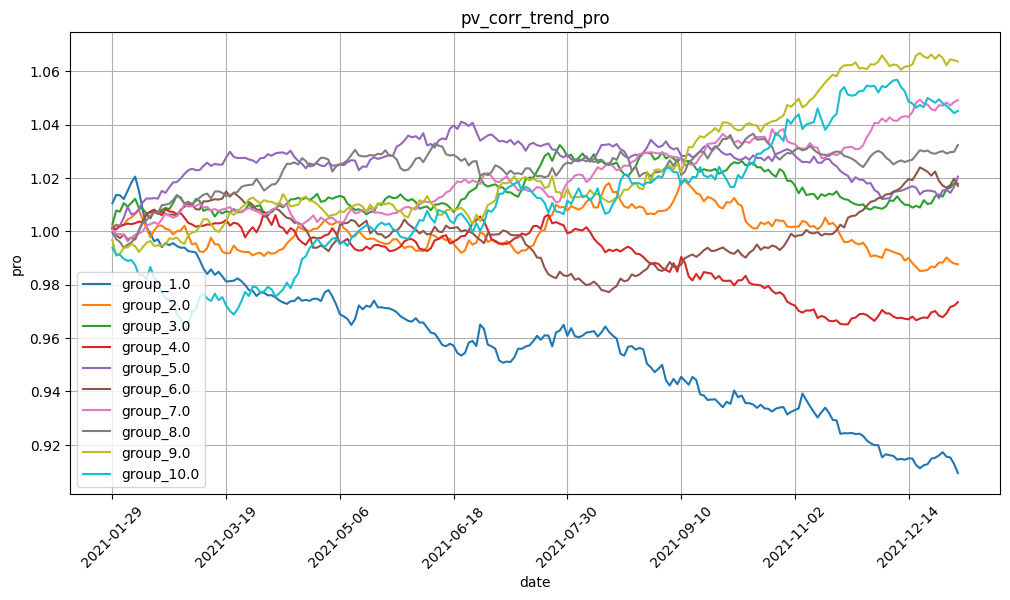

,factor_name,ic:,icir:,多头收益率:,多头波动率:,多头ir:,多头最大回撤:,对冲收益率:,对冲波动率:,对冲ir:,对冲最大回撤:
0,pv_corr_trend,0.006,0.157,0.211,0.161,1.307,10.4,-0.157,0.065,-2.411,16.4


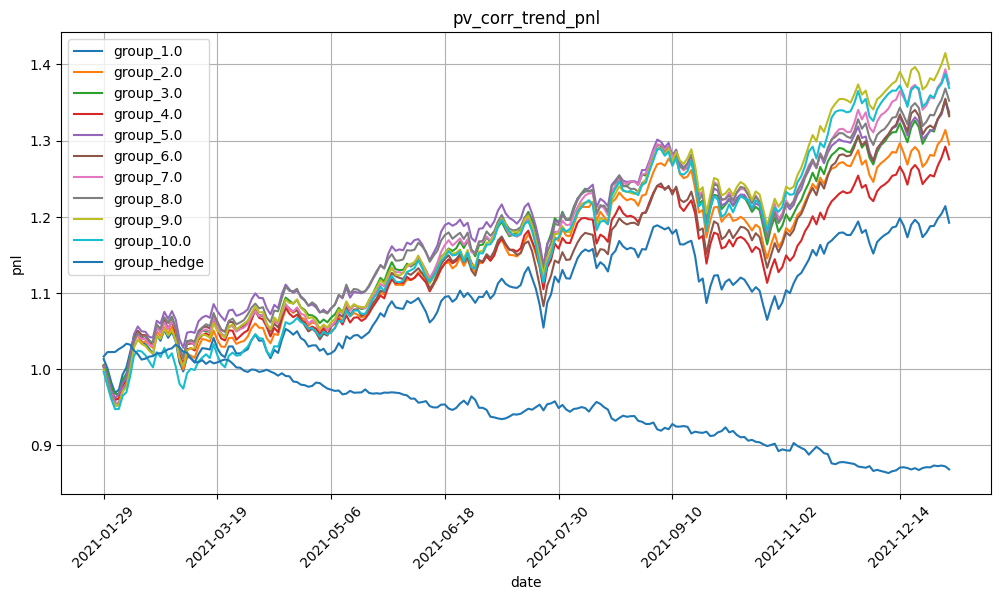

In [45]:
from backtest import BacktestAnalyzer
start_date = '2021-01-29'
end_date = '2021-12-31'
trade_date = '/content/drive/MyDrive/factor/data/date.pkl'
factor_path = '/content/drive/MyDrive/factor/feature/factor_1_8_pv_corr_trend'
ret_path = '/content/drive/MyDrive/factor/data/data_ret1'
ud_path = '/content/drive/MyDrive/factor/data/data_ud'
group = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

analyzer = BacktestAnalyzer(start_date, end_date, trade_date, factor_path, ret_path, ud_path, group)
analyzer.prepare_data()
analyzer.calculate_effectiveness()
analyzer.result

In [46]:
standard_pv_corr_deRet20 = cs_standard(pv_corr_deRet20)
standard_pv_corr_trend = cs_standard(-pv_corr_trend)
cpv = standard_pv_corr_deRet20.iloc[19:] + standard_pv_corr_trend

long_format_cpv = cpv.reset_index().melt(id_vars=['date'], var_name='code', value_name='cpv')
long_format_cpv.tail()

,date,code,cpv
1034651,2021-12-27,689009.XSHG,0.669720
1034652,2021-12-28,689009.XSHG,1.054463
1034653,2021-12-29,689009.XSHG,1.613966
1034654,2021-12-30,689009.XSHG,1.812340
1034655,2021-12-31,689009.XSHG,2.121160


In [47]:
#将日期列转换为datetime类型
df = long_format_cpv
df['date']=pd.to_datetime(df['date'])

#保存文件夹路径
output_folder='/content/drive/MyDrive/factor/feature/factor_1_8_cpv'
selected_columns=['code', 'date', 'cpv']

os.makedirs(output_folder,exist_ok=True)

#创建日期索引并检查是否在dateframe中存在
date_index=pd.date_range(df['date'].min(),df['date'].max(),freq='D')
existing_dates=[d for d in date_index if d in df['date'].values]

#遍历每个日期如果它在dataframe中存在 则将其保存为单独的csv文件
for date in tqdm(existing_dates):
    group=df.loc[df['date']==date,selected_columns]
    filename=os.path.join(output_folder,f'{date.strftime("%Y-%m-%d")}.csv')
    group=group.sort_values(by='code',ascending=True)
    group = group.drop(columns = ['date'])
    group.to_csv(filename,index=False)

100%|██████████| 224/224 [00:13<00:00, 16.82it/s]


100%|██████████| 224/224 [00:17<00:00, 12.65it/s]


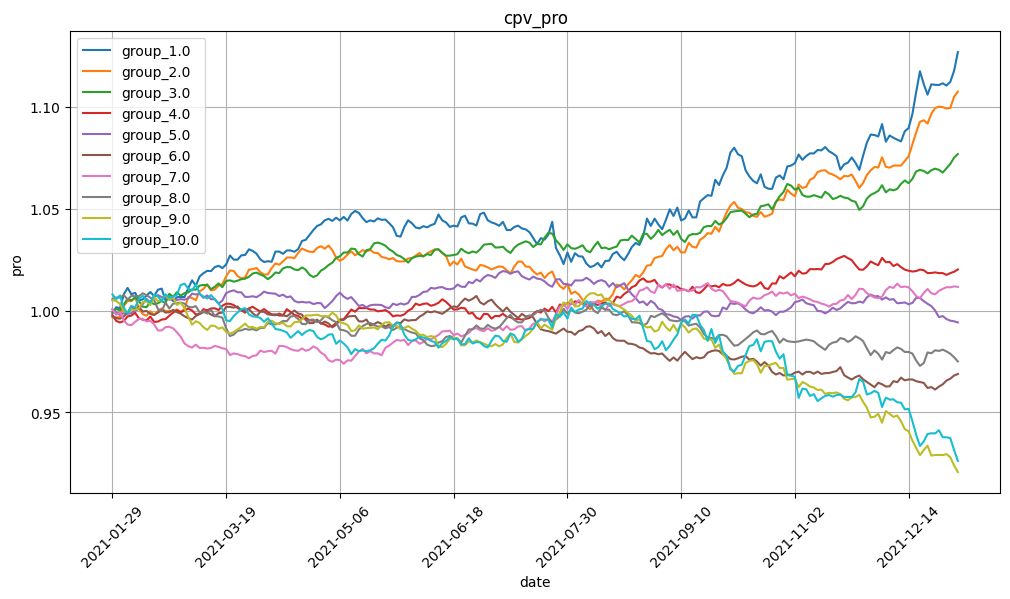

,factor_name,ic:,icir:,多头收益率:,多头波动率:,多头ir:,多头最大回撤:,对冲收益率:,对冲波动率:,对冲ir:,对冲最大回撤:
0,cpv,-0.009,-0.163,0.453,0.142,3.187,8.0,0.221,0.092,2.395,5.0


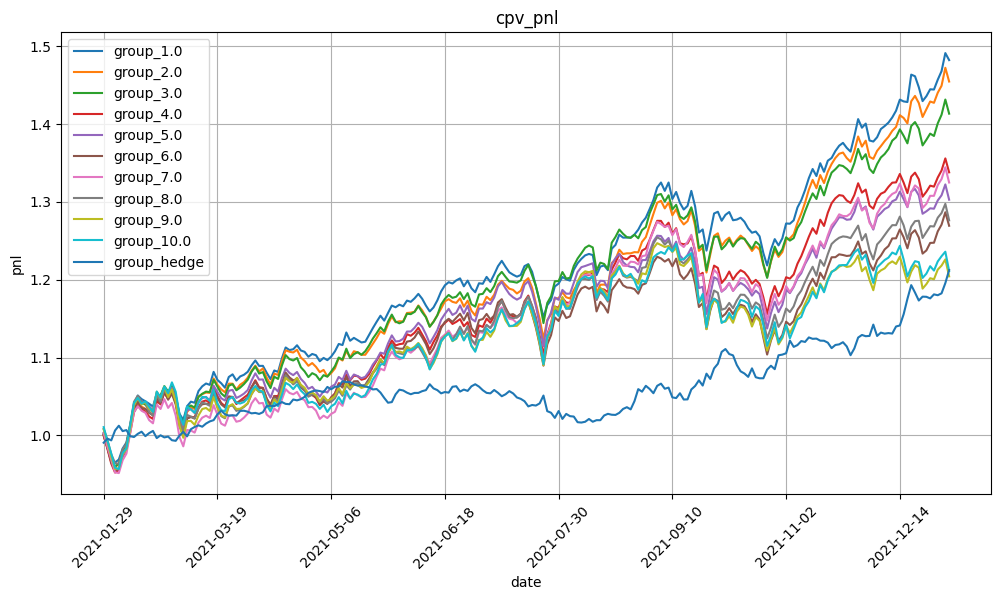

In [48]:
from backtest import BacktestAnalyzer
start_date = '2021-01-29'
end_date = '2021-12-31'
# trade_date = './data/date.pkl'
# factor_path = './feature/factor_1_8_cpv'
# ret_path = './data/data_ret1'
# ud_path = './data/data_ud'

trade_date = '/content/drive/MyDrive/factor/data/date.pkl'
factor_path = '/content/drive/MyDrive/factor/feature/factor_1_8_cpv'
ret_path = '/content/drive/MyDrive/factor/data/data_ret1'
ud_path = '/content/drive/MyDrive/factor/data/data_ud'
group = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

analyzer = BacktestAnalyzer(start_date, end_date, trade_date, factor_path, ret_path, ud_path, group)
analyzer.prepare_data()
analyzer.calculate_effectiveness()
analyzer.result